In [22]:
#First I start by importing all necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
import pickle

In [24]:
path = 'BBC News Summary/News Articles' # This is the path to the News_Articles folder
categories = ['business', 'entertainment', 'politics', 'sport', 'tech'] # Here I define the categories, each one corresponding to folder names)
data = [] # Now I initialize a list to hold the data

for category in categories: #For iterator through each category folder
    category_path = os.path.join(path, category)
    for filename in os.listdir(category_path): #Loop through each file in the folder
        if filename.endswith('.txt'): #Just for checking to process al txt files
            file_path = os.path.join(category_path, filename)
            
            with open(file_path, 'r', encoding='unicode_escape') as file: #Now I ppen and read the file
                text = file.read()
            data.append((text, category)) #Then I append the text and label to the data list

df = pd.DataFrame(data, columns=['text', 'label']) #Now I need to create a DataFrame from the data

# Display the first few rows of the DataFrame
print(df.head())


                                                text     label
0  Watchdog probes Vivendi bond sale\n\nFrench st...  business
1  Japanese banking battle at an end\n\nJapan's S...  business
2  Enron bosses in $168m payout\n\nEighteen forme...  business
3  Home loan approvals rising again\n\nThe number...  business
4  India's Maruti sees profits jump\n\nIndia's bi...  business


### Next Section is a quick data exploratory analysis.

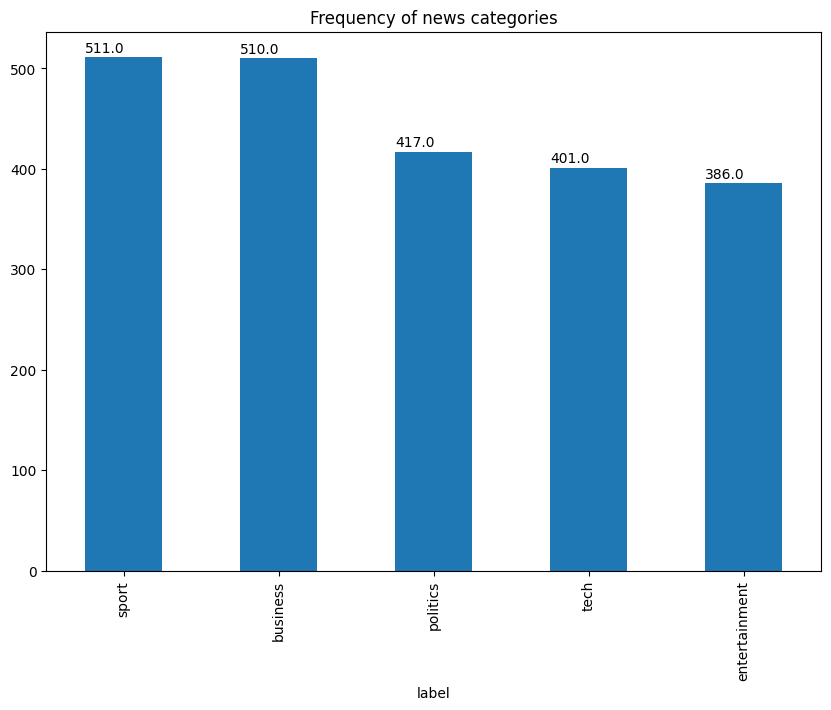

In [25]:
ax = df['label'].value_counts().plot(kind='bar', figsize=(10,7)) #This is a bar plot to get the amount of articles per category

for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x(), p.get_height()+5))
plt.title("Frequency of news categories")
plt.show()

In [26]:
def remove_ns(text): #I make quick function to removing the '\n' from the news articles
    return text.replace("\n", " ")

df['text'] = df['text'].apply(remove_ns) #Now I apply this to the DataFrame
df.head() #To check if everything is correct I print the DataFrame

,text,label
0,Watchdog probes Vivendi bond sale French stoc...,business
1,Japanese banking battle at an end Japan's Sum...,business
2,Enron bosses in $168m payout Eighteen former ...,business
3,Home loan approvals rising again The number o...,business
4,India's Maruti sees profits jump India's bigg...,business


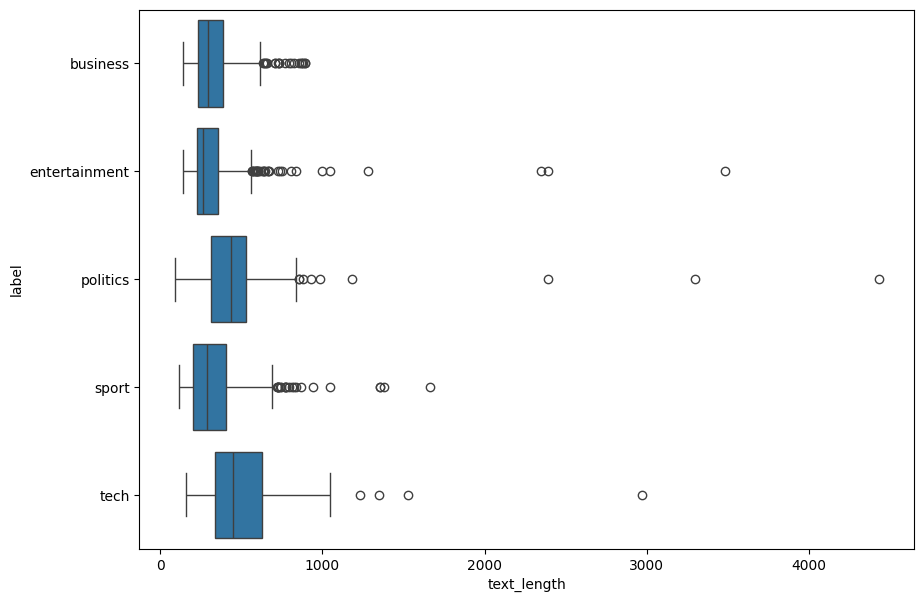

In [27]:
df['text_length'] = df['text'].str.split().apply(len) #I create a new column which stores the length of the news articles
fig,ax = plt.subplots(figsize=(10,7)) #Create subplot
sns.boxplot(x='text_length', y='label', data=df, ax=ax) #Now I plot a boxplot showing the distribution of the length of news articles across categories

plt.show()

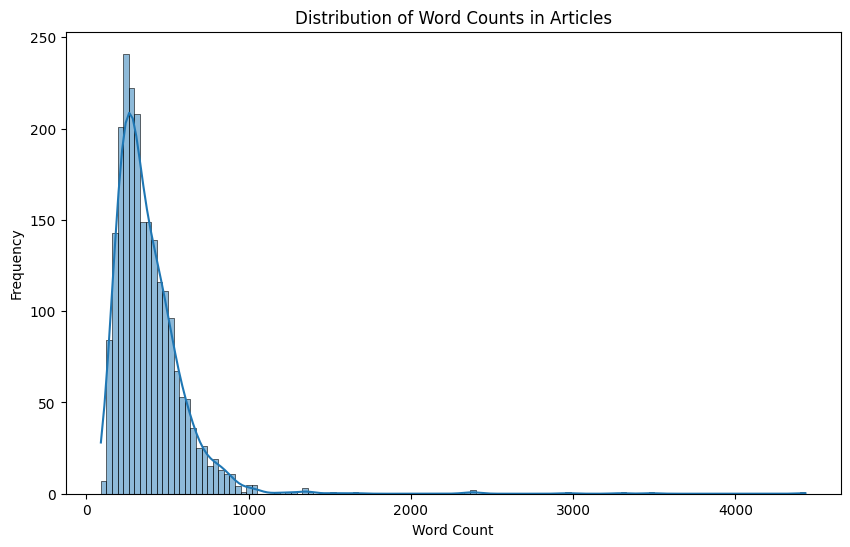

In [28]:
#Other interesting plot is to visualize word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Word Counts in Articles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [29]:
category_word_count = df.groupby('label')['text_length'].mean() #Here I calculate average word count per category
print(category_word_count)


label
business         328.880392
entertainment    330.621762
politics         453.973621
sport            329.262231
tech             502.695761
Name: text_length, dtype: float64


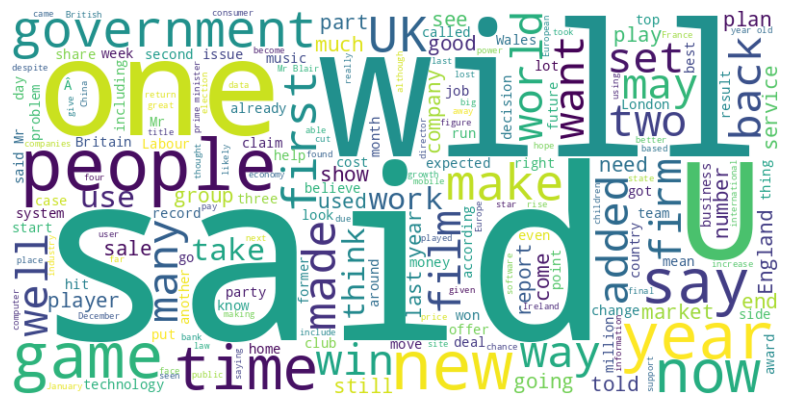

In [30]:
all_text = ' '.join(df['text'].values) #I decided to combine all the text for word cloud generation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text) #Now I generate word cloud

plt.figure(figsize=(10, 5)) #Afertwards I plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


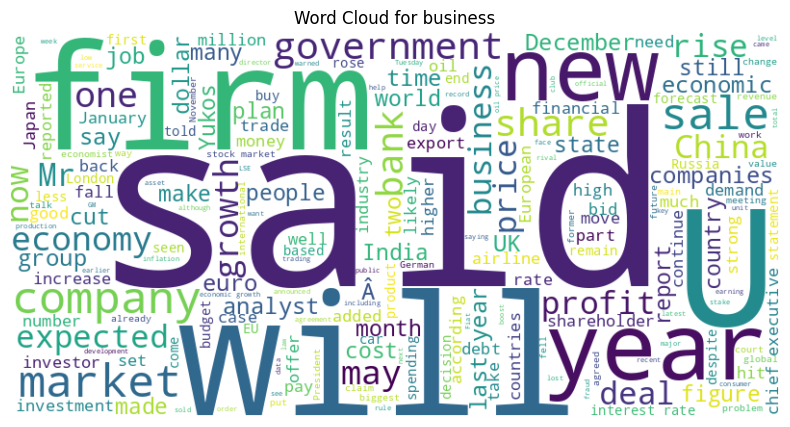

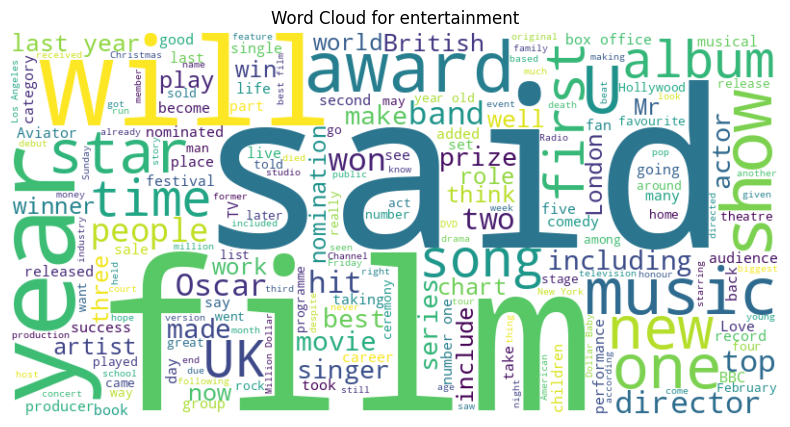

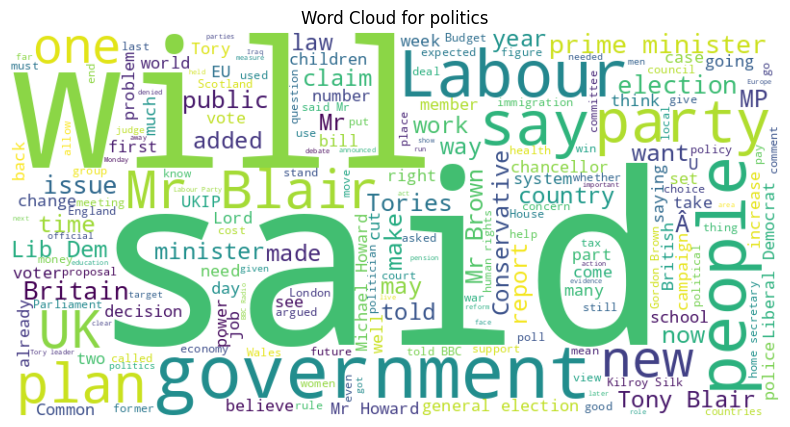

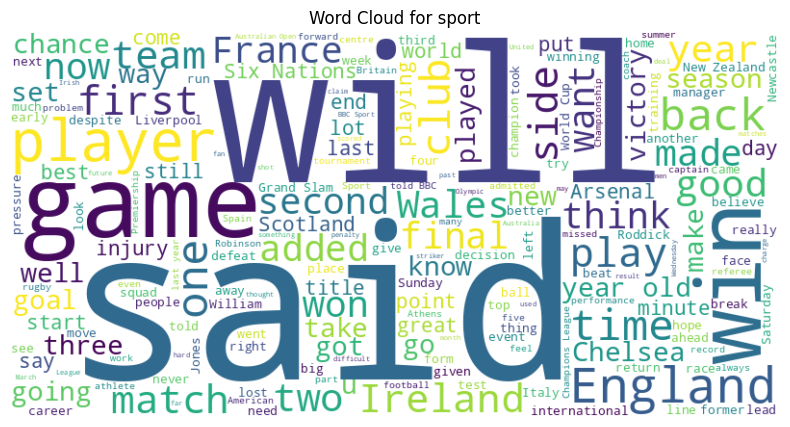

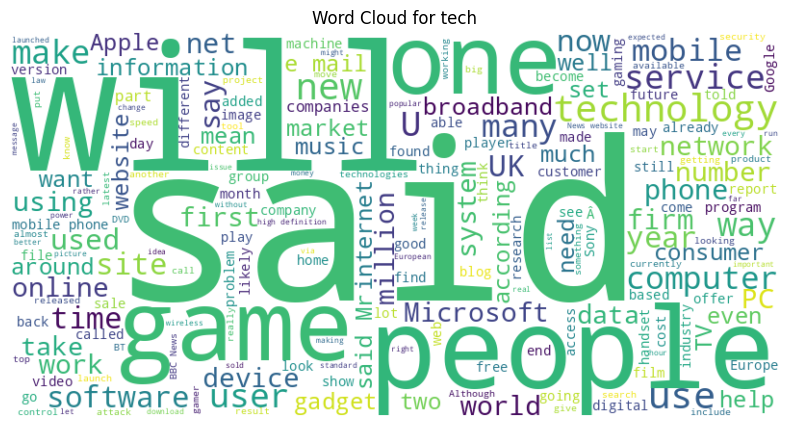

In [31]:
for category in categories: #This loop is to create the word cloud but filter for each category
    text = ' '.join(df[df['label'] == category]['text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()


In [32]:
def get_top_n_words(corpus, n=10): #Now I build a simple funciton to get most common words in a category
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

for category in categories: #I print the top 10 words for each category
    category_text = df[df['label'] == category]['text']
    top_words = get_top_n_words(category_text, 10)
    print(f"Top words in {category} category: {top_words}")

Top words in business category: [('the', 9029), ('to', 5044), ('of', 4362), ('in', 4046), ('a', 3233), ('and', 3138), ('is', 1599), ('The', 1577), ('for', 1562), ('that', 1523)]
Top words in entertainment category: [('the', 6456), ('and', 2933), ('of', 2926), ('to', 2853), ('in', 2643), ('a', 2496), ('The', 1699), ('for', 1507), ('was', 1129), ('on', 1113)]
Top words in politics category: [('the', 10569), ('to', 5958), ('of', 4449), ('and', 3776), ('a', 3659), ('in', 3114), ('for', 1859), ('is', 1806), ('that', 1761), ('on', 1737)]
Top words in sport category: [('the', 8651), ('to', 4663), ('a', 3673), ('in', 3521), ('and', 3446), ('of', 2792), ('for', 1711), ('is', 1470), ('on', 1432), ('was', 1421)]
Top words in tech category: [('the', 9777), ('to', 6264), ('of', 5304), ('and', 4611), ('a', 4074), ('in', 3160), ('is', 2511), ('that', 2484), ('for', 1998), ('The', 1736)]


### Now this section is about classification model

In [33]:
nltk.download('stopwords') # Download NLTK stopwords 
#Stopwords are words that don't carry significant meaning in the context of text analysis and are often removed from text data to improve the model's performance.
stop_words = set(stopwords.words('english'))

#This is a function to preprocess text
def preprocess_text(text):
    text = text.lower() #I convert text to lowercase
    text = re.sub(r'\W', ' ', text) #Now I remove punctuation and special characters    
    text = re.sub(r'\d+', '', text) #Now I remove digits
    text = ' '.join([word for word in text.split() if word not in stop_words]) #I remove stopwords
    return text

df['text'] = df['text'].apply(preprocess_text) # Apply preprocessing to the 'text' column
print(df.head()) #Just to make sure I print DataFrame


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/franceri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text     label  text_length
0  watchdog probes vivendi bond sale french stock...  business          287
1  japanese banking battle end japan sumitomo mit...  business          278
2  enron bosses payout eighteen former enron dire...  business          352
3  home loan approvals rising number mortgages ap...  business          228
4  india maruti sees profits jump india biggest c...  business          210


In [34]:
label_encoder = LabelEncoder() #Now I initialize a label encoder object
label_encoder.fit(df['label']) #I fit the label encoder with its corresponding columns
df['label'] = label_encoder.transform(df['label']) #Finally I encode the categorical data to numerical

In [35]:
#Now I split the data into training and testing sets (80/20 split as its a very common rule)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42,stratify=df['label'],shuffle=True)

#Just to check I display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1780,) (1780,)
Testing set shape: (445,) (445,)


In [36]:
vectorizer = TfidfVectorizer(max_features=5000) #I initialize the TF-IDF vectorizer. It converts raw text data into numerical features suitable for machine learning models
X_train_tfidf = vectorizer.fit_transform(X_train) #Now fit and transform the training data
X_test_tfidf = vectorizer.transform(X_test) #Finally transform the test data

In [37]:
model = LogisticRegression(max_iter=1000) #Now I make the logistic regression model
#Afterwards I define the hyperparameter that will try each different combination to find the best model 
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  #Inverse of regularization
    'solver': ['lbfgs', 'liblinear'],  #Possible solvers
    'penalty': ['l2']  #Types of penalization
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1) #This is the configuration of GridSearchCV
grid_search.fit(X_train_tfidf, y_train) #Now I fit my model
                
print("Mejores parámetros:", grid_search.best_params_) #Finally I print what are the best parameters and score
print("Mejor puntuación:", grid_search.best_score_)

y_pred = grid_search.predict(X_test_tfidf) #Make predictions with test data and see the results with classification report
print(classification_report(y_test, y_pred))

Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación: 0.9780898876404495
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           1       1.00      0.99      0.99        77
           2       0.96      0.96      0.96        84
           3       0.99      1.00      1.00       102
           4       1.00      0.99      0.99        80

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



In [38]:
#I save the model into a pkl file
with open('logisticregression_model.pkl','wb') as f:
    pickle.dump(grid_search,f)

In [39]:
#I save the vectorizer into a pkl file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)